In [1]:
import os
import numpy as np
from core.data_provider import datasets_factory
from core.models.model_factory import Model
from core.utils import preprocess
import core.trainer as trainer
import math 
# export CUDA_VISIBLE_DEVICES=0
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/xiao/anaconda3/envs/pytorch111/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/xiao/anaconda3/envs/pytorch111/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [2]:
class configs:
    is_training = 0
    device = "cuda"
    dataset_name = "motion"
    gen_frm_dir = "results/motion_predrnn"
    input_length = 1
    total_length = 12
    img_width = 60
    img_channel = 3
    model_name = "predrnn_memory_decoupling"# "predrnn_memory_decoupling"
    pretrained_model = "checkpoints/model.ckpt-73000"
    num_hidden = "128,128,128,128"
    filter_size = 5
    stride = 1
    patch_size = 4 
    layer_norm = 0
    lr = 0.0003
    batch_size = 1
    reverse_scheduled_sampling = 0
    num_save_samples = 10
    decouple_beta = 0.1
    visual = False
    visual_path = ""

In [17]:
import matplotlib.pyplot as plt
test_maze = np.load("Data/mazes_60_test.npy")
test_config = np.load("Data/mazes_config_test.npy")
print ('test_maze shape', test_maze.shape)
print ('test_config', test_config.shape)

test_maze shape (1700, 60, 60)
test_config (1700, 4)


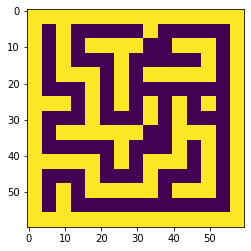

In [18]:
plt.imshow(test_maze[0])

In [19]:
model = Model(configs)
model.load(configs.pretrained_model)

load model: checkpoints/model.ckpt-73000


In [20]:
def augmentation(img, start_x, start_y, channel=1):
    h, w = 7, 7
    for i in range(-3, 4):
        for j in range(-3, 4):
            x, y = start_x + i, start_y + j
            if 0<=x<=(img.shape[0]-1) and 0 <=y<=(img.shape[0]-1) and img[x,y,0]<0.1:
                img[x,y,channel] = 1.0
    return img

In [21]:
def IsInCollision(curr_x, curr_y, obs):
    cf = False
    for i in range(obs.shape[0]):
#         print ('checking obstacle', i)
        if abs(obs[i, 0] - curr_x) < obs[i,2]/2.0 and  abs(obs[i, 1] - curr_y) < obs[i,3]/2.0:
            return True
    return False

In [28]:
import time

Threshold = 0.25
DISCRETIZATION_STEP= 0.01
max_itr = 20
max_sample = 10
success_rate = 0
all_path = []
all_time = 0


for map_id in range(test_maze.shape[0]):
    print ('Testing seen map', map_id)
    map_path = []


    start_x, start_y = test_config[map_id, :-2]
    goal_x, goal_y = test_config[map_id, -2:]
    path = [(start_x, start_y)]
    print ('configuration', test_config[map_id])

    first_frame = np.zeros((configs.img_width, configs.img_width, configs.img_channel))
    first_frame[:,:,0] = np.copy(test_maze[map_id])
    first_frame = augmentation(first_frame, start_x, start_y, 1)
    first_frame = augmentation(first_frame, goal_x, goal_y, 2)


    video = np.zeros((5,configs.total_length,configs.img_width,configs.img_width,configs.img_channel)) 
    video[0, :, :, :, 0] = first_frame[:,:,0]
    video[0, :, :, :, 2] = first_frame[:,:,2]
    video[0, 0, :, :, 1] = first_frame[:,:,1] #the intial state
    configs.input_length = 1
    real_input_flag = np.zeros(
            (configs.batch_size,
             configs.total_length - configs.input_length - 1,
             configs.img_width // configs.patch_size,
             configs.img_width // configs.patch_size,
             configs.patch_size ** 2 * configs.img_channel))

    no_step = 0
    no_frame = 0
    s_time = time.time()
    while True:
        if no_step >= configs.total_length - 2:
            no_frame = configs.total_length - 2
        else:
            no_frame = no_step

        test_dat = preprocess.reshape_patch(video, configs.patch_size)          
        predicted_frame = model.test(test_dat, real_input_flag)        
        predicted_frame = preprocess.reshape_patch_back(predicted_frame, configs.patch_size)

        predicted_pos = predicted_frame[0,no_frame,:,:,1]
        sample_pools = np.unravel_index(np.argsort(predicted_pos, axis=None)[::-1], predicted_pos.shape)

        for idx in range(sample_pools[0].shape[0]):
            next_x, next_y = sample_pools[0][idx], sample_pools[1][idx]
            if first_frame[next_x, next_y, 0] > 0.9 or (next_x, next_y) in path:
                continue
            last_dir = np.sign([path[-1][0] - start_x, path[-1][1] - start_y])
            curr_dir = np.sign([next_x - path[-1][0], next_y - path[-1][1]])
            if np.sum(np.abs(curr_dir - last_dir)) >= 4:
                continue

            #collision detection
            last_x, last_y = path[-1]
            distTotal = math.sqrt((next_x - last_x)**2 + (next_y - last_y)**2)

            collision_flag = False
            if distTotal>0:
                incrementTotal = distTotal/DISCRETIZATION_STEP
                numSegments = int(math.floor(incrementTotal))
                x_dist = (next_x - last_x)/numSegments
                y_dist = (next_y - last_y)/numSegments

                for pt in range(numSegments):
                    last_x = last_x + x_dist
                    last_y = last_y + y_dist
                    if first_frame[int(last_x), int(last_y), 0] > 0.9:
                        collision_flag = True
                        break

            if not collision_flag:
                no_step += 1
                path.append((next_x, next_y))
                break

        if abs(next_x - goal_x) + abs(next_y - goal_y) <= 6:
            success_rate += 1
            path.append((goal_x, goal_y))
            path.append('#') #denote the path is successful
            break

        if no_step >= configs.total_length - 2:
            video[0, :-1] = video[0, 1:]
            video[0, -2] = augmentation(video[0, -2], next_x, next_y)
        else:
            video[0, no_frame + 1] = augmentation(video[0, no_frame + 1], next_x, next_y)
        configs.input_length = no_frame + 1
        real_input_flag = np.zeros(
                (configs.batch_size,
                 configs.total_length - configs.input_length - 1,
                 configs.img_width // configs.patch_size,
                 configs.img_width // configs.patch_size,
                 configs.patch_size ** 2 * configs.img_channel))

        if no_step > max_itr:
            print ('failed!')
            break
    all_time += time.time() - s_time
    print ('path', path)
    

Testing seen map 0
configuration [26 39  4 14]
path [(26, 39), (21, 34), (27, 29), (18, 28), (28, 28), (19, 28), (9, 39), (7, 25), (7, 22), (6, 14), (4, 14), '#']
Testing seen map 1
configuration [38 10 39 10]
path [(38, 10), (40, 7), (39, 10), '#']
Testing seen map 2
configuration [29 18  9 14]
path [(29, 18), (32, 21), (10, 22), (5, 18), (7, 16), (9, 14), '#']
Testing seen map 3
configuration [33 46 29 46]
path [(33, 46), (32, 44), (29, 46), '#']
Testing seen map 4
configuration [14 45 19 31]
path [(14, 45), (17, 50), (23, 48), (23, 31), (19, 31), '#']
Testing seen map 5
configuration [12 51 51 46]
path [(12, 51), (17, 50), (27, 54), (46, 50), (55, 41), (55, 45), (51, 46), '#']
Testing seen map 6
configuration [39 24 27 34]
path [(39, 24), (37, 25), (33, 21), (26, 31), (27, 34), '#']
Testing seen map 7
configuration [ 4 35 52 38]
path [(4, 35), (8, 25), (16, 23), (28, 33), (33, 30), (39, 34), (34, 30), (45, 41), (54, 41), (52, 38), '#']
Testing seen map 8
configuration [54 55 53 36]


path [(47, 39), (30, 37), (30, 42), (26, 47), (9, 48), (11, 52), '#']
Testing seen map 65
configuration [44 16 42 45]
path [(44, 16), (49, 21), (53, 21), (54, 45), (55, 34), (53, 50), (54, 47), (45, 48), (42, 45), '#']
Testing seen map 66
configuration [54 27 27 21]
path [(54, 27), (55, 34), (50, 39), (40, 36), (37, 33), (36, 23), (31, 22), (27, 21), '#']
Testing seen map 67
configuration [ 4 54 27 26]


KeyboardInterrupt: 

In [12]:
print (len(valid_task))

1700


In [14]:
valid_maze = []
valid_config = []
for i in range(len(valid_task)):
    map_id, task_id = valid_task[i]
    valid_maze.append(test_maze[map_id])
    valid_config.append(test_config[map_id, task_id])
valid_maze = np.array(valid_maze)
valid_config = np.array(valid_config)
np.save("Data/mazes_60_test.npy", valid_maze)
np.save("Data/mazes_config_test.npy", valid_config)
    
    

In [16]:
print (valid_maze.shape)
print (valid_config.shape)

(1700, 60, 60)
(1700, 4)
